# IRIS dataset vs. Recent deep learning methods

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import sys
from chainer import Chain, ChainList, cuda, gradient_check, Function, Link, \
    optimizers, serializers, utils, Variable, datasets, using_config, training, iterators
from chainer.training import extensions
from chainer import functions as F
from chainer import links as L
import os

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 26

In [3]:
class MLP(Chain):
    def __init__(self, ls, act=F.relu, nobias=False, last_act=False):
        '''
        ls <list of int> : [784, 100, 10]
        '''
        self.l = {}
        self.ls = ls
        self.act = act
        self.last_act = last_act
        for i in range(len(ls)-1):
            self.l['l{}'.format(i)] = L.Linear(ls[i], ls[i+1], nobias=nobias)
        super(MLP, self).__init__(**self.l)
    def __call__(self, x):
        '''
        x <Variable>
        returns <Variable>
        '''
        h = x
        for i in range(len(self.ls)-1):
            h = self.l['l{}'.format(i)](h)
            if self.last_act or i + 2 < len(self.ls): h = self.act(h)
        return h
    
class SCM(Chain):
    def __init__(self, ls, act=F.relu, nobias=False, last_act=False):
        '''
        ls <list of int> : [784, 100, 10]
        '''
        self.l = {}
        self.ls = ls
        self.act = act
        self.last_act = last_act
        assert len(ls) >= 3 # The last layer is F.linear (because of soft-committee machine)
        for i in range(len(ls)-2):
            self.l['l{}'.format(i)] = L.Linear(ls[i], ls[i+1], nobias=nobias)
        super(SCM, self).__init__(**self.l)
    def __call__(self, x):
        '''
        x <Variable>
        returns <Variable>
        '''
        h = x
        for i in range(len(self.ls)-1):
            if i < len(self.ls)-2:
                h = self.l['l{}'.format(i)](h)
            else:
                h = F.linear(h, np.ones([self.ls[i+1], self.ls[i]]).astype(np.float32)) # all 1
            if self.last_act or i + 2 < len(self.ls): h = self.act(h)
        return h    

In [4]:
def name2idx(s):
    if s[:6]=='setosa': return 0
    elif s[:10]=='versicolor': return 1
    else: return 2
def get_iris_data():
    with open('iris.csv', 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines[1:]:
        datum = line.split(',')
        data.append((np.array(list(map(float, datum[:4]))), name2idx(datum[4])))
    return data
iris_tds = get_iris_data()

In [5]:
iris_x = np.array([td[0] for td in iris_tds]).astype(np.float32)
iris_y = np.array([td[1] for td in iris_tds]).astype(np.int32)

In [6]:
np.random.seed(314)
_ = np.random.permutation(150); train_idx, test_idx = _[:90], _[90:]

In [7]:
train_x, test_x = iris_x[train_idx], iris_x[test_idx]
train_y, test_y = iris_y[train_idx], iris_y[test_idx]

MNIST データもロードしておく．

In [8]:
mnist_train, mnist_test = datasets.get_mnist()

## Training iris dataset with MLP (4-4-3, sigmoid, SGD, bs=10)

In [114]:
%%time
for i in range(100):
    mdl = L.Classifier(MLP([4, 4, 3], act=F.sigmoid))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
    trn.run()

CPU times: user 51min 7s, sys: 1min 33s, total: 52min 41s
Wall time: 54min 58s


In [126]:
os.system('mv result result_exp1')

0

<Figure size 1080x1080 with 0 Axes>

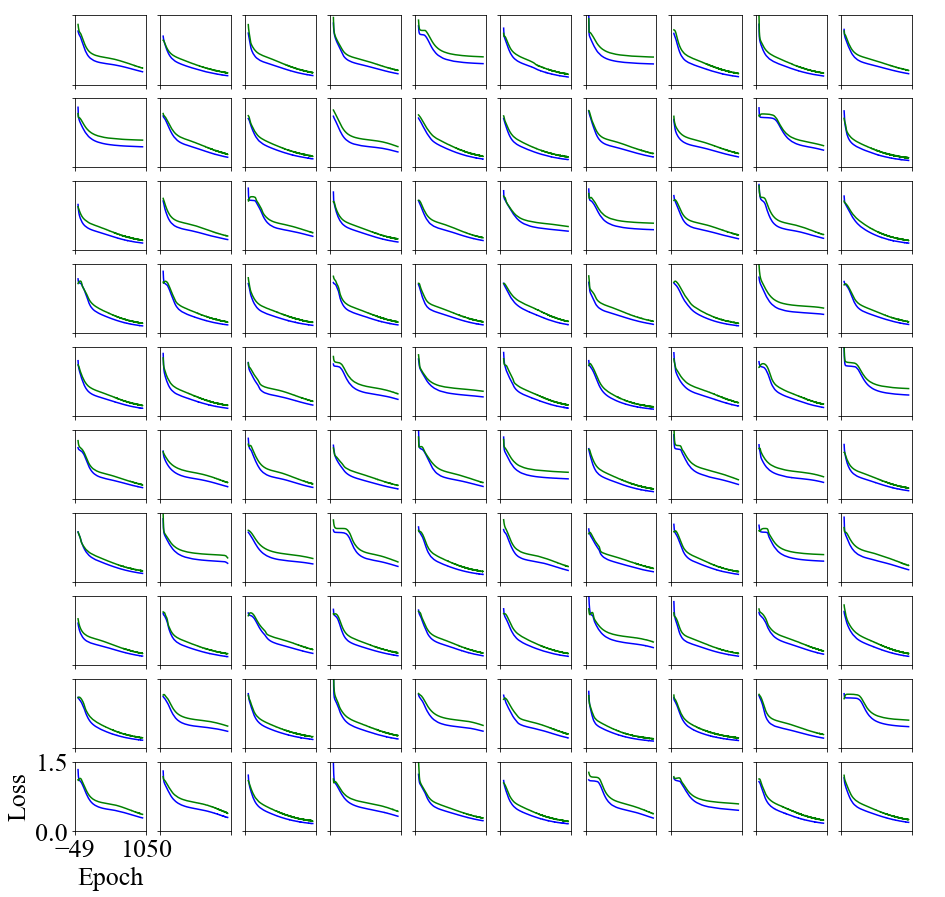

In [10]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('./iris_with_deep_learning_results/result_exp1/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, test_loss, color='g')
    plt.ylim(0, 1.5)
    # plt.plot(epoch, train_acc, color='r')
    # plt.plot(epoch, test_acc, color='m')
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

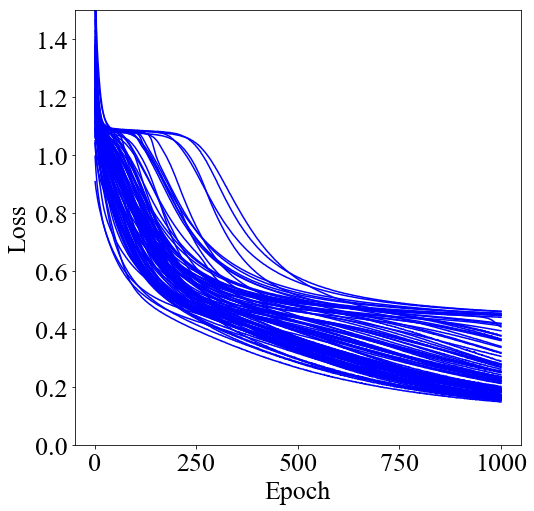

In [11]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('./iris_with_deep_learning_results/result_exp1/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
    # plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

### Plot accuracies with red curves

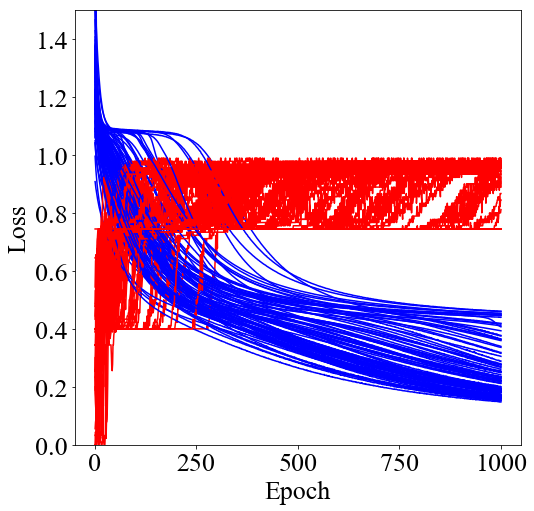

In [12]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('./iris_with_deep_learning_results/result_exp1/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

### Plot only 10 trials with highest final training loss

<Figure size 576x576 with 0 Axes>

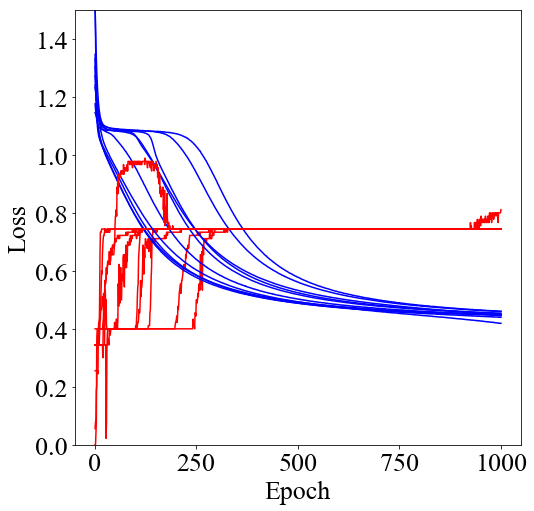

In [14]:
last_train_loss = []
for i in range(100):
    with open('./iris_with_deep_learning_results/result_exp1/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    last_train_loss.append(rslt[-1]['main/loss'])
ranking = np.argsort(last_train_loss)[::-1]

plt.figure(figsize=(8,8))
for i in ranking[:10]:
    with open('./iris_with_deep_learning_results/result_exp1/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

#### On training iris dataset, plateaus indeed bring low accuracies.

### More iterations

In [104]:
%%time
mdl = L.Classifier(MLP([4, 4, 3], act=F.sigmoid))
opt = optimizers.SGD()
opt.setup(mdl)
train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y), 10, shuffle=True)
test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y), 10, repeat=False)
upd = training.StandardUpdater(train_itr, opt)
trn = training.Trainer(upd, (20000, 'epoch'))
trn.extend(extensions.LogReport(log_name='log_long'))
trn.extend(extensions.Evaluator(test_itr, mdl))
# trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
trn.run()

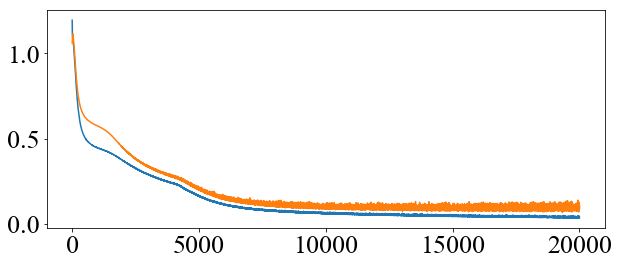

In [16]:
plt.figure(figsize=(10,4))
with open('./iris_with_deep_learning_results/result_long/log_long', 'r') as f:
    rslt = json.load(f)
epoch = [r['epoch'] for r in rslt]
train_loss = [r['main/loss'] for r in rslt]
test_loss = [r['validation/main/loss'] for r in rslt]
plt.plot(epoch, train_loss)
plt.plot(epoch, test_loss)
plt.show()

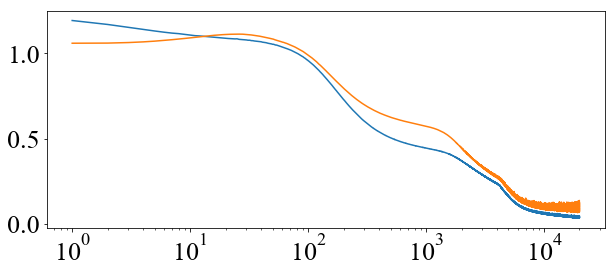

In [17]:
plt.figure(figsize=(10,4))
with open('./iris_with_deep_learning_results/result_long/log_long', 'r') as f:
    rslt = json.load(f)
epoch = [r['epoch'] for r in rslt]
train_loss = [r['main/loss'] for r in rslt]
test_loss = [r['validation/main/loss'] for r in rslt]
plt.plot(epoch, train_loss)
plt.plot(epoch, test_loss)
plt.xscale('log')
plt.show()

## Change activation from sigmoid to ReLU

In [131]:
%%time
for i in range(100):
    mdl = L.Classifier(MLP([4, 4, 3], act=F.relu))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
    trn.run()

CPU times: user 52min 16s, sys: 1min 40s, total: 53min 57s
Wall time: 56min 4s


In [ ]:
os.system('mv result result_exp2')

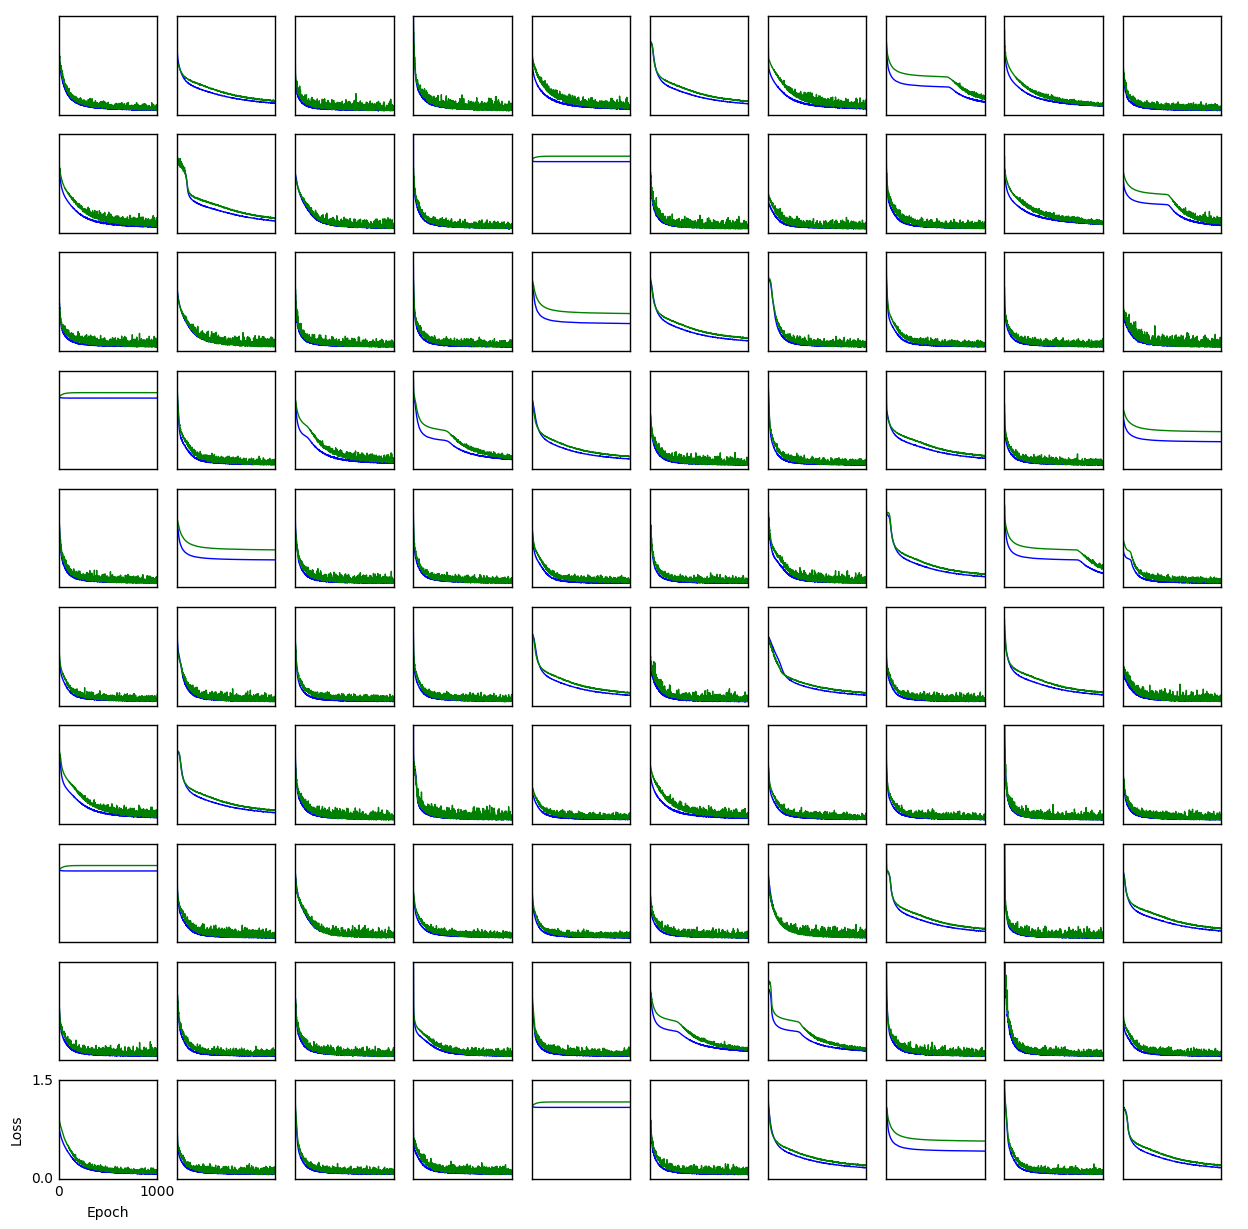

In [138]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp2/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss)
    plt.plot(epoch, test_loss)
    plt.ylim(0, 1.5)
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

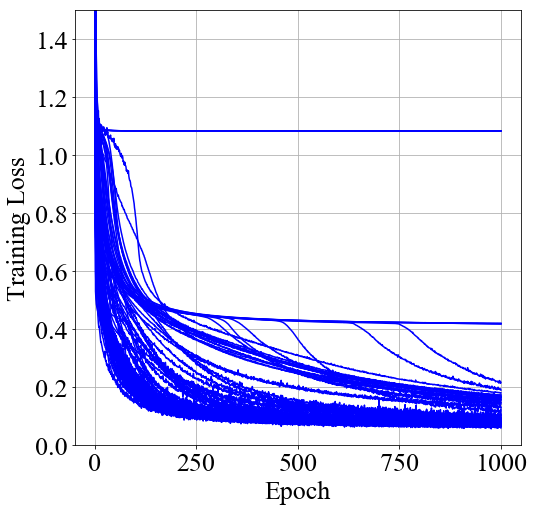

In [4]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('iris_with_deep_learning_results/result_exp2/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid()
plt.ylim(0, 1.5)
plt.show()

### Plot only 10 trials with highest final training loss

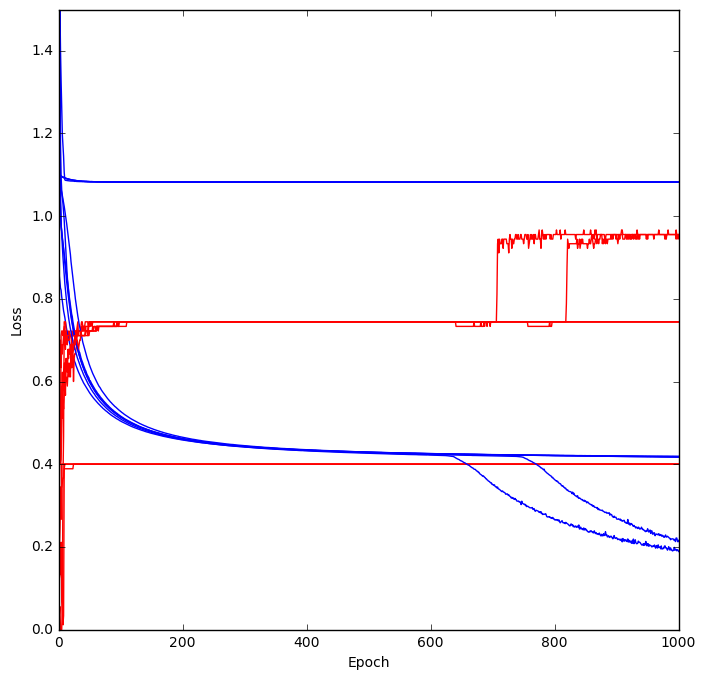

In [20]:
last_train_loss = []
for i in range(100):
    with open('result_exp2/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    last_train_loss.append(rslt[-1]['main/loss'])
ranking = np.argsort(last_train_loss)[::-1]

plt.figure(figsize=(8,8))
for i in ranking[:10]:
    with open('result_exp2/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

#### On training iris dataset, plateaus indeed bring low accuracies.

## Change optimization from SGD to Adam

In [140]:
%%time
for i in range(100):
    mdl = L.Classifier(MLP([4, 4, 3], act=F.relu))
    opt = optimizers.Adam()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
    trn.run()

CPU times: user 53min 29s, sys: 1min 34s, total: 55min 3s
Wall time: 56min 52s


In [141]:
os.system('mv result result_exp3')

0

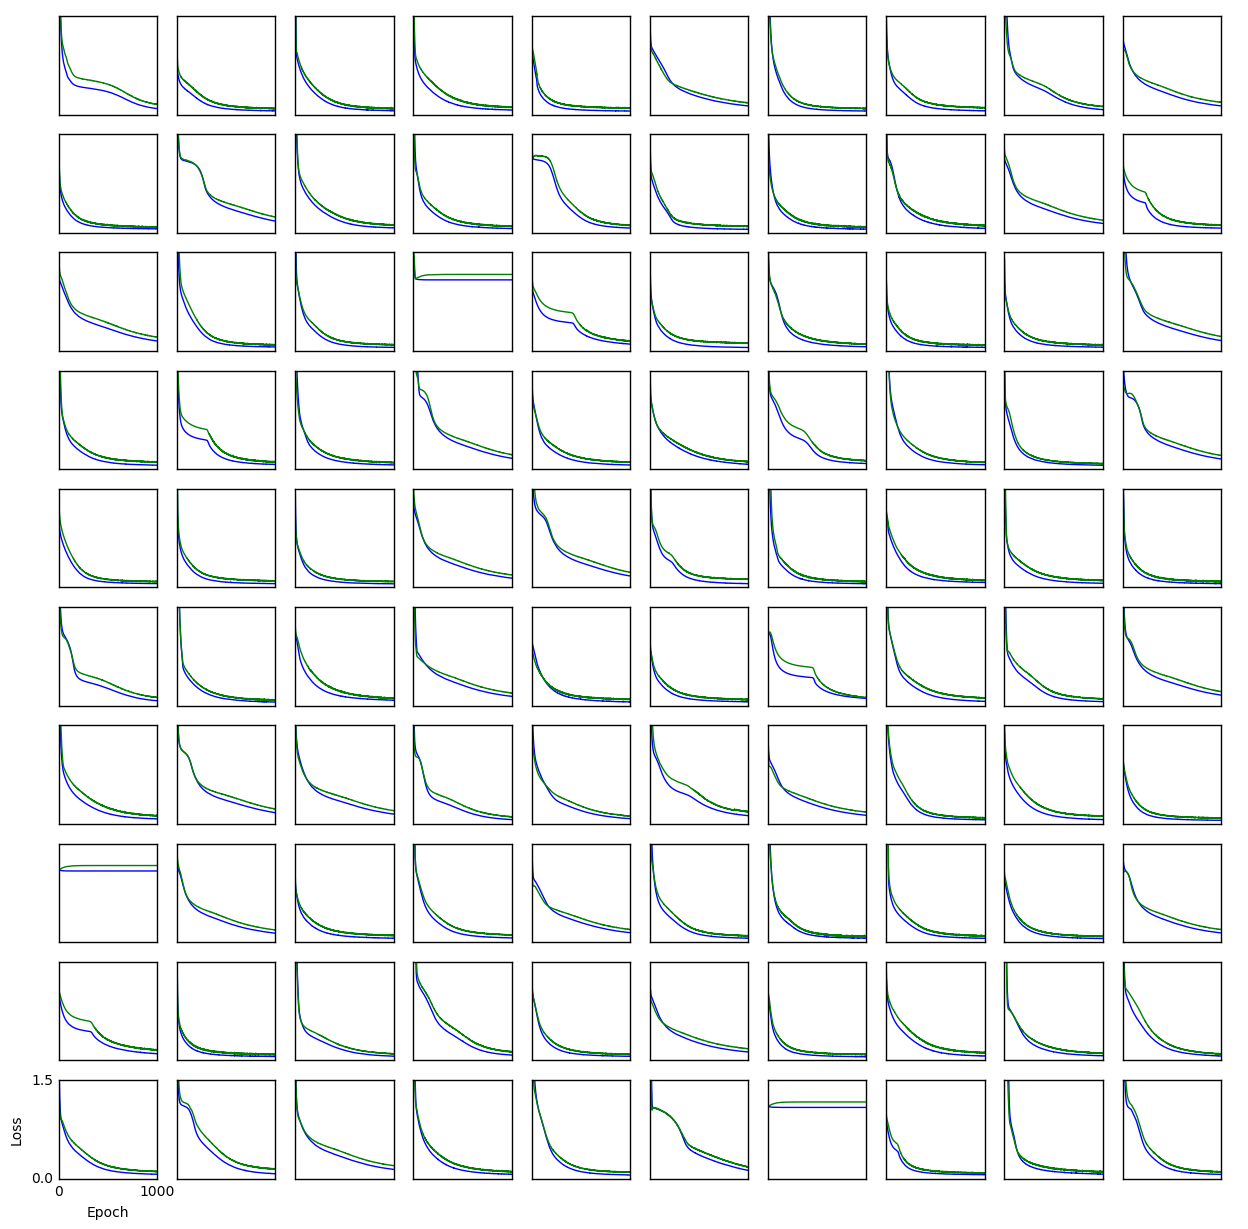

In [142]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp3/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss)
    plt.plot(epoch, test_loss)
    plt.ylim(0, 1.5)
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

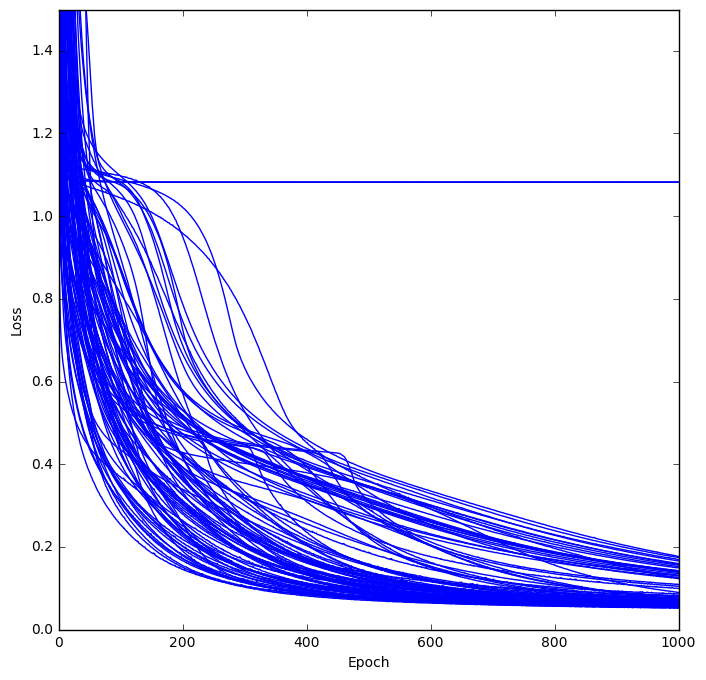

In [143]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp3/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

#### Plateau shortens but does not disappear.

# MLP, 4-4-3, sigmoid, SGD で，ただし入力をMNIST-likeに小さく正規化してみよう．

In [53]:
# MNIST の共分散行列の全固有値の平均を調べよう
mnist_train, mnist_test = datasets.get_mnist()

In [54]:
mnist_train_x = np.array([data[0] for data in mnist_train])
mnist_train_x.shape

(60000, 784)

In [55]:
x = mnist_train_x - np.mean(mnist_train_x, axis=0)
# x = mnist_train_x

In [56]:
cov = np.dot(x.T, x) / x.shape[0]

In [57]:
# 全ての固有値の平均値
mnist_m1 = np.trace(cov)/cov.shape[0]
mnist_m1

0.06725133195215342

In [59]:
# IRIS の共分散行列の全固有値の平均を調べよう
x = train_x - np.mean(train_x, axis=0)
cov = np.dot(x.T, x) / x.shape[0]
iris_m1 = np.trace(cov)/cov.shape[0]
iris_m1

1.1311802864074707

## IRISデータを np.sqrt(0.06/1.13) 倍する．

In [64]:
the_ratio = np.sqrt(mnist_m1/iris_m1)
the_ratio

0.24382853605794114

In [65]:
%%time
for i in range(100):
    mdl = L.Classifier(MLP([4, 4, 3], act=F.sigmoid))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x * the_ratio, train_y), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x * the_ratio, test_y), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
    trn.run()

CPU times: user 52min 7s, sys: 1min 46s, total: 53min 54s
Wall time: 56min 16s


In [66]:
os.system('mv result result_exp4')

0

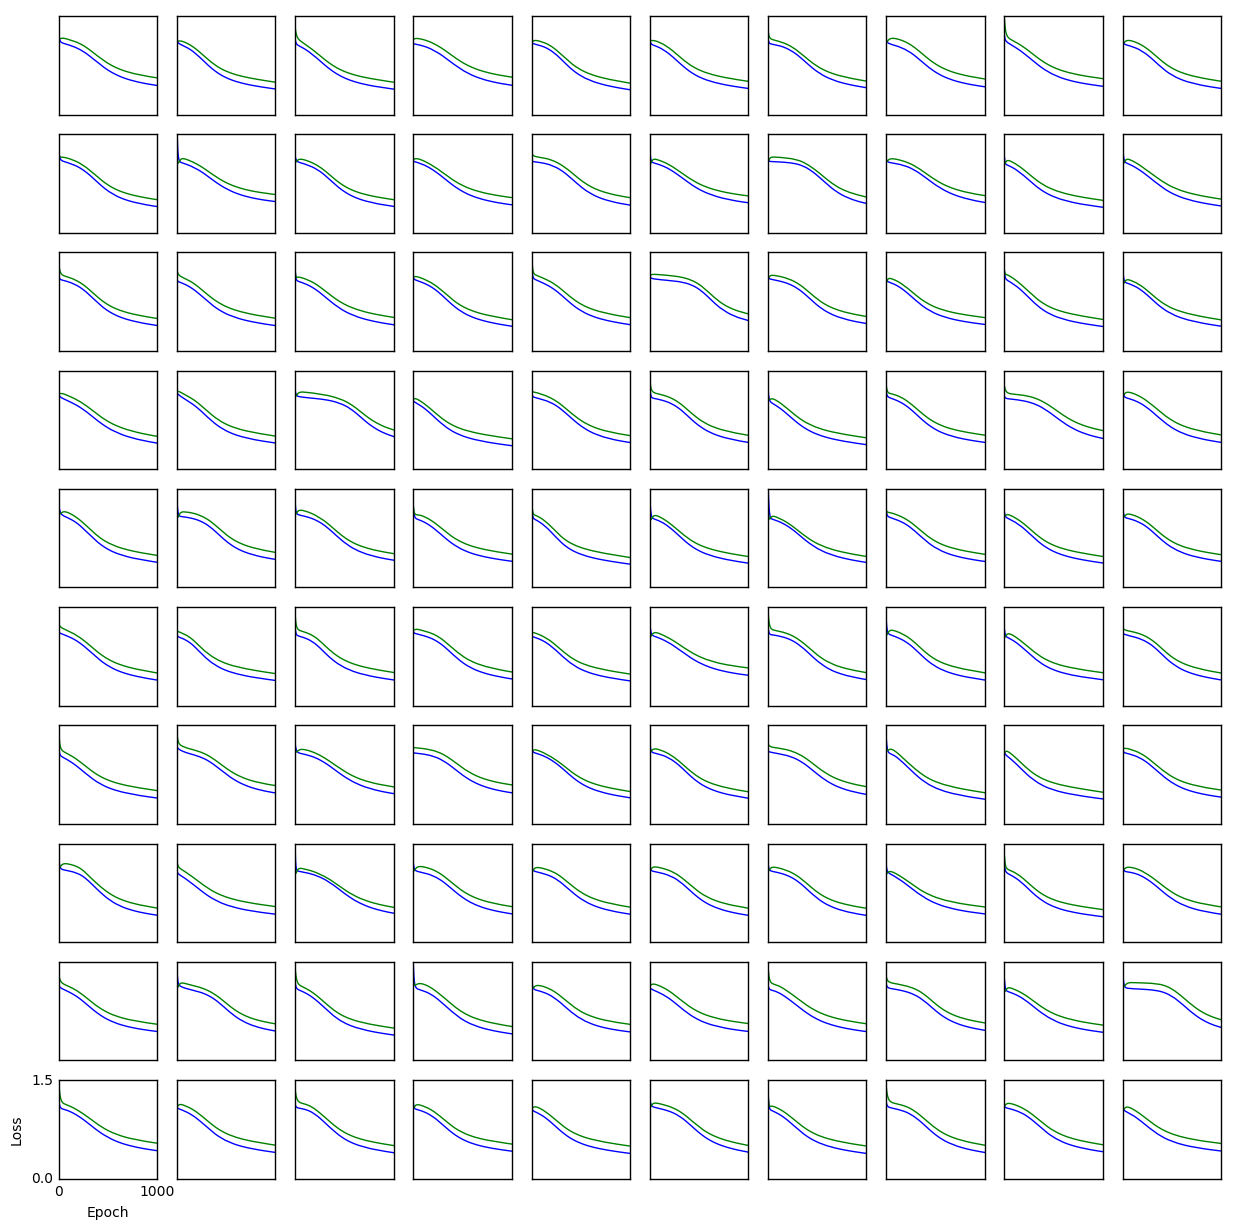

In [67]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp4/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss)
    plt.plot(epoch, test_loss)
    plt.ylim(0, 1.5)
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

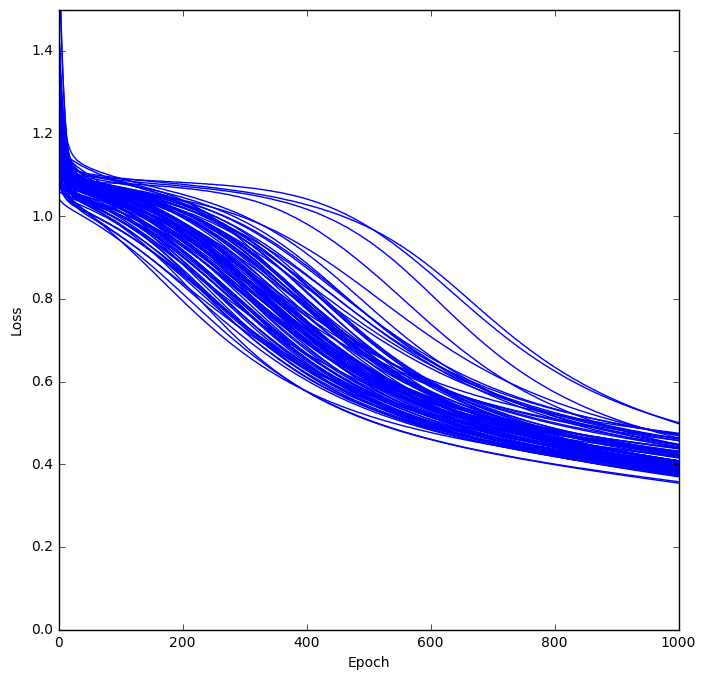

In [68]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp4/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

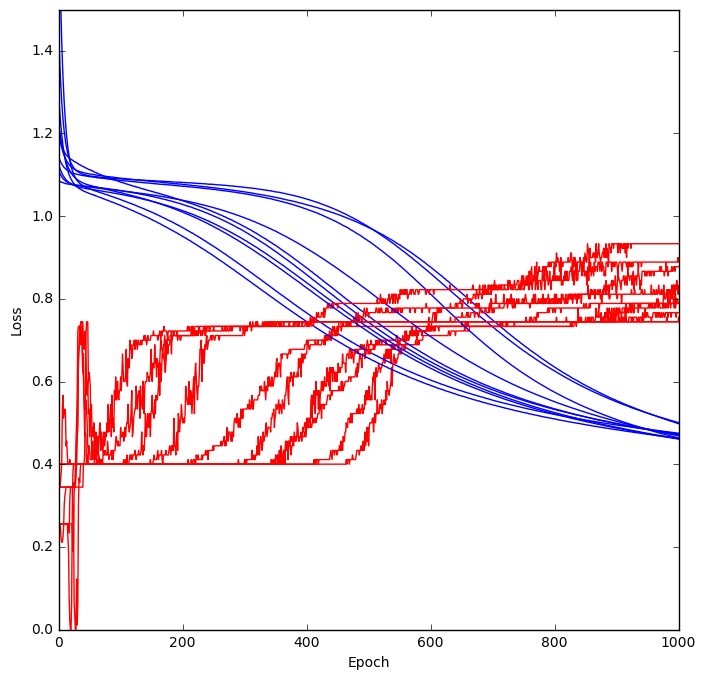

In [70]:
last_train_loss = []
for i in range(100):
    with open('result_exp4/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    last_train_loss.append(rslt[-1]['main/loss'])
ranking = np.argsort(last_train_loss)[::-1]

plt.figure(figsize=(8,8))
for i in ranking[:10]:
    with open('result_exp4/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

## IRIS データをもっと小さくしてみると？

In [71]:
%%time
for i in range(100):
    mdl = L.Classifier(MLP([4, 4, 3], act=F.sigmoid))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x * 0.05, train_y), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x * 0.05, test_y), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
    trn.run()

CPU times: user 52min 42s, sys: 1min 43s, total: 54min 25s
Wall time: 1h 40min 3s


In [72]:
os.system('mv result result_exp5')

0

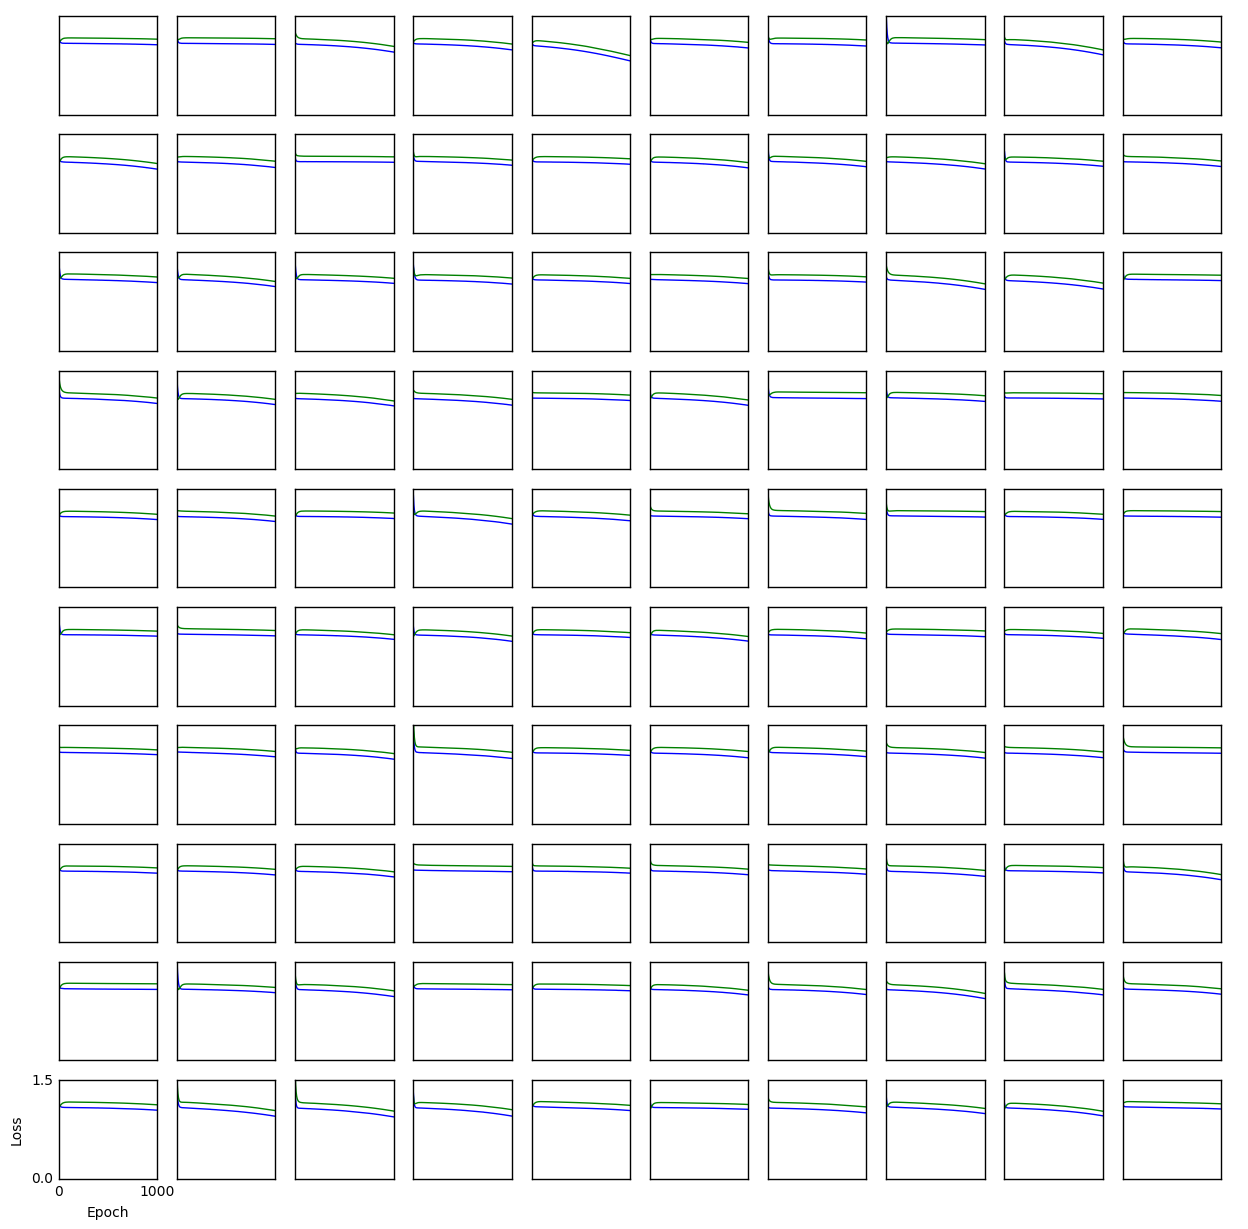

In [73]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp5/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss)
    plt.plot(epoch, test_loss)
    plt.ylim(0, 1.5)
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

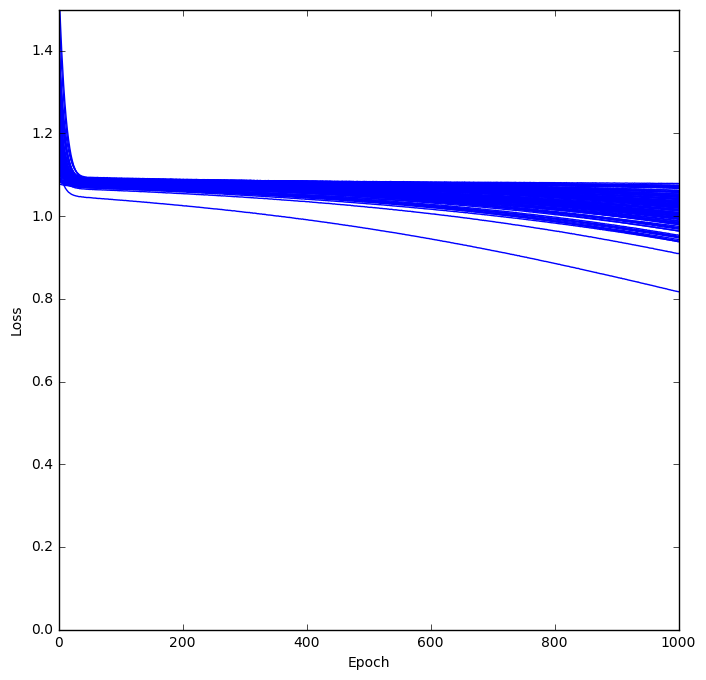

In [74]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp5/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

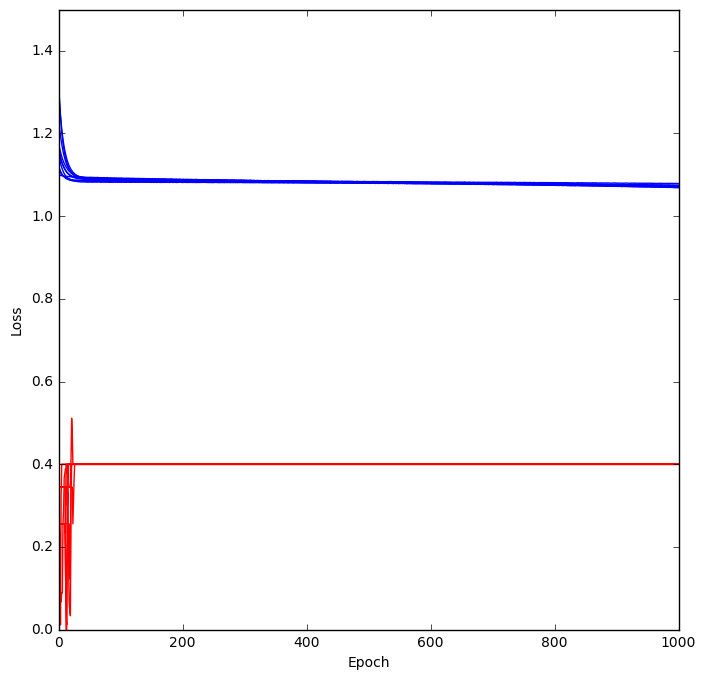

In [76]:
last_train_loss = []
for i in range(100):
    with open('result_exp5/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    last_train_loss.append(rslt[-1]['main/loss'])
ranking = np.argsort(last_train_loss)[::-1]

plt.figure(figsize=(8,8))
for i in ranking[:10]:
    with open('result_exp5/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

# Above experiments are performed with two-layer MLP. In the below we use soft-committee machine.

## with SCM. 4-4-3, sigmoid, SGD, bs=10

In [11]:
%%time
for i in range(100):
    mdl = L.Classifier(SCM([4, 4, 3], act=F.sigmoid))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
    trn.run()

CPU times: user 49min 48s, sys: 1min 35s, total: 51min 23s
Wall time: 53min 26s


In [12]:
os.system('mv result result_exp11_orz')

0

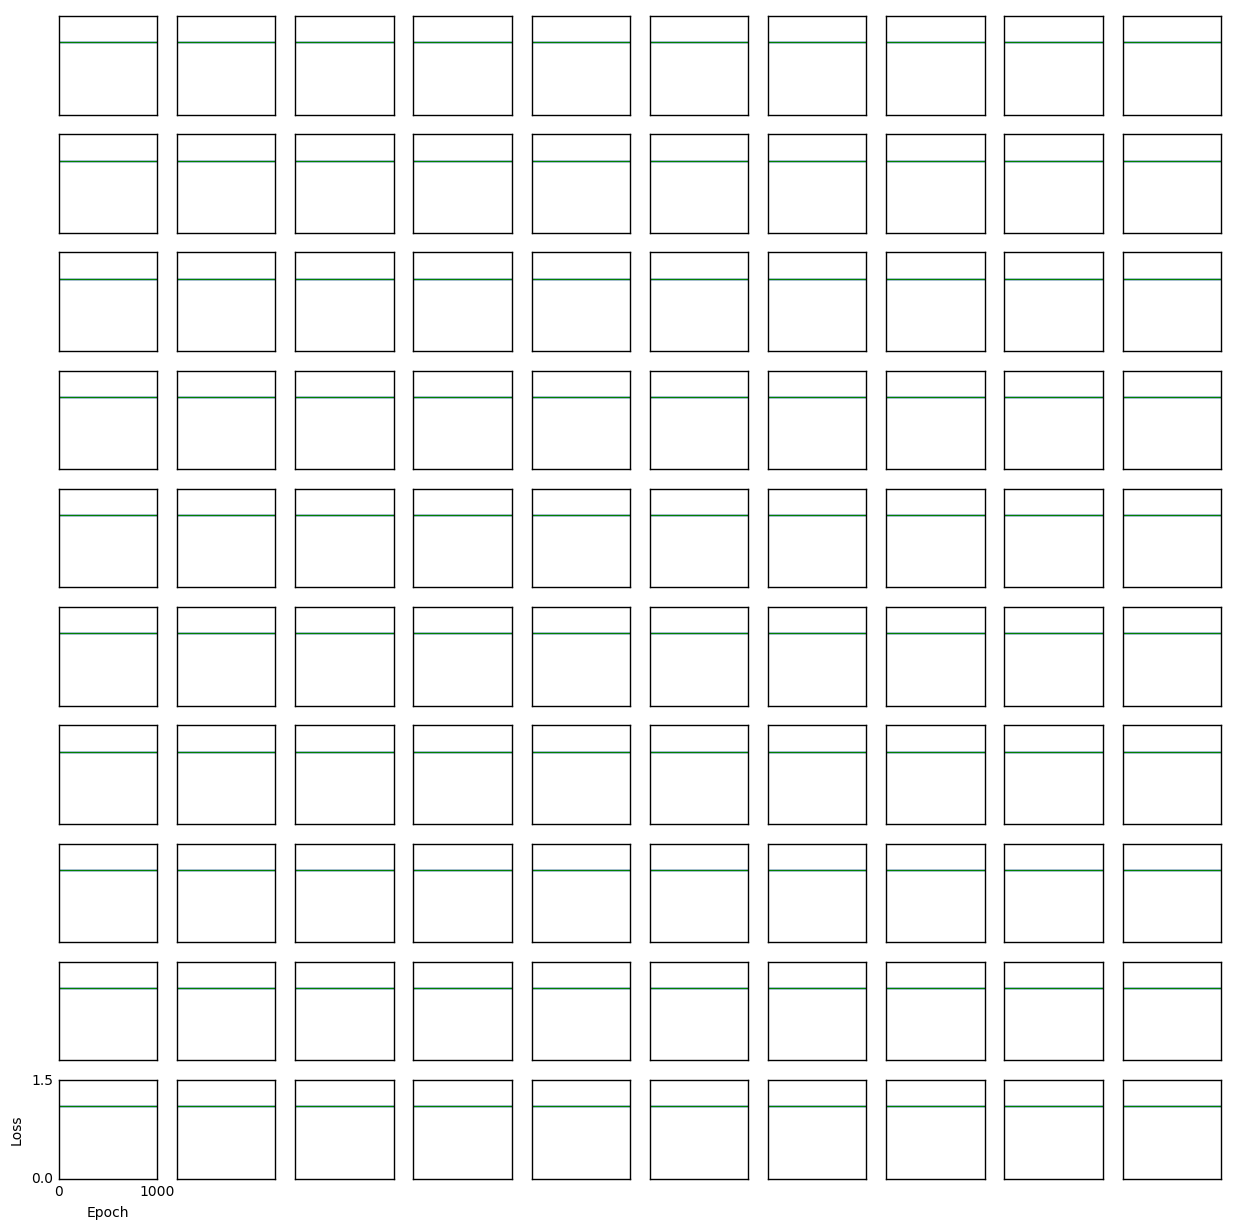

In [19]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp11/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, test_loss, color='g')
    plt.ylim(0, 1.5)
    # plt.plot(epoch, train_acc, color='r')
    # plt.plot(epoch, test_acc, color='m')
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

In [20]:
# 実は出力複数素子のSCMでsoftmax_cross_entropyするのは自明な応答しか出せない．
scm = SCM([4,4,3], act=F.sigmoid)
scm(np.random.randn(10,4).astype(np.float32))

variable([[1.3950236, 1.3950236, 1.3950236],
          [2.178783 , 2.178783 , 2.178783 ],
          [1.2236602, 1.2236602, 1.2236602],
          [1.9145519, 1.9145519, 1.9145519],
          [2.798338 , 2.798338 , 2.798338 ],
          [1.8262384, 1.8262384, 1.8262384],
          [1.7992369, 1.7992369, 1.7992369],
          [1.9350157, 1.9350157, 1.9350157],
          [1.3012395, 1.3012395, 1.3012395],
          [2.3739774, 2.3739774, 2.3739774]])

## With SCM. 4-2-1 (sigmoid_cross_ent {0,2} vs {1}), sigmoid, SGD, bs=10

In [30]:
# train_y, test_y を {0,2} vs {1} に書き換える必要がある．
train_y_02_vs_1 = np.array([{0:0,1:1,2:0}[v] for v in train_y],dtype=np.int32)
test_y_02_vs_1 = np.array([{0:0,1:1,2:0}[v] for v in test_y],dtype=np.int32)

In [33]:
%%time
for i in range(100):
    mdl = L.Classifier(SCM([4, 2, 1], act=F.sigmoid), lossfun=lambda y,t:F.sigmoid_cross_entropy(F.flatten(y), t))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y_02_vs_1), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y_02_vs_1), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss']))
    trn.run()

CPU times: user 52min 12s, sys: 1min 42s, total: 53min 54s
Wall time: 56min 45s


In [34]:
os.system('mv result result_exp11')

0

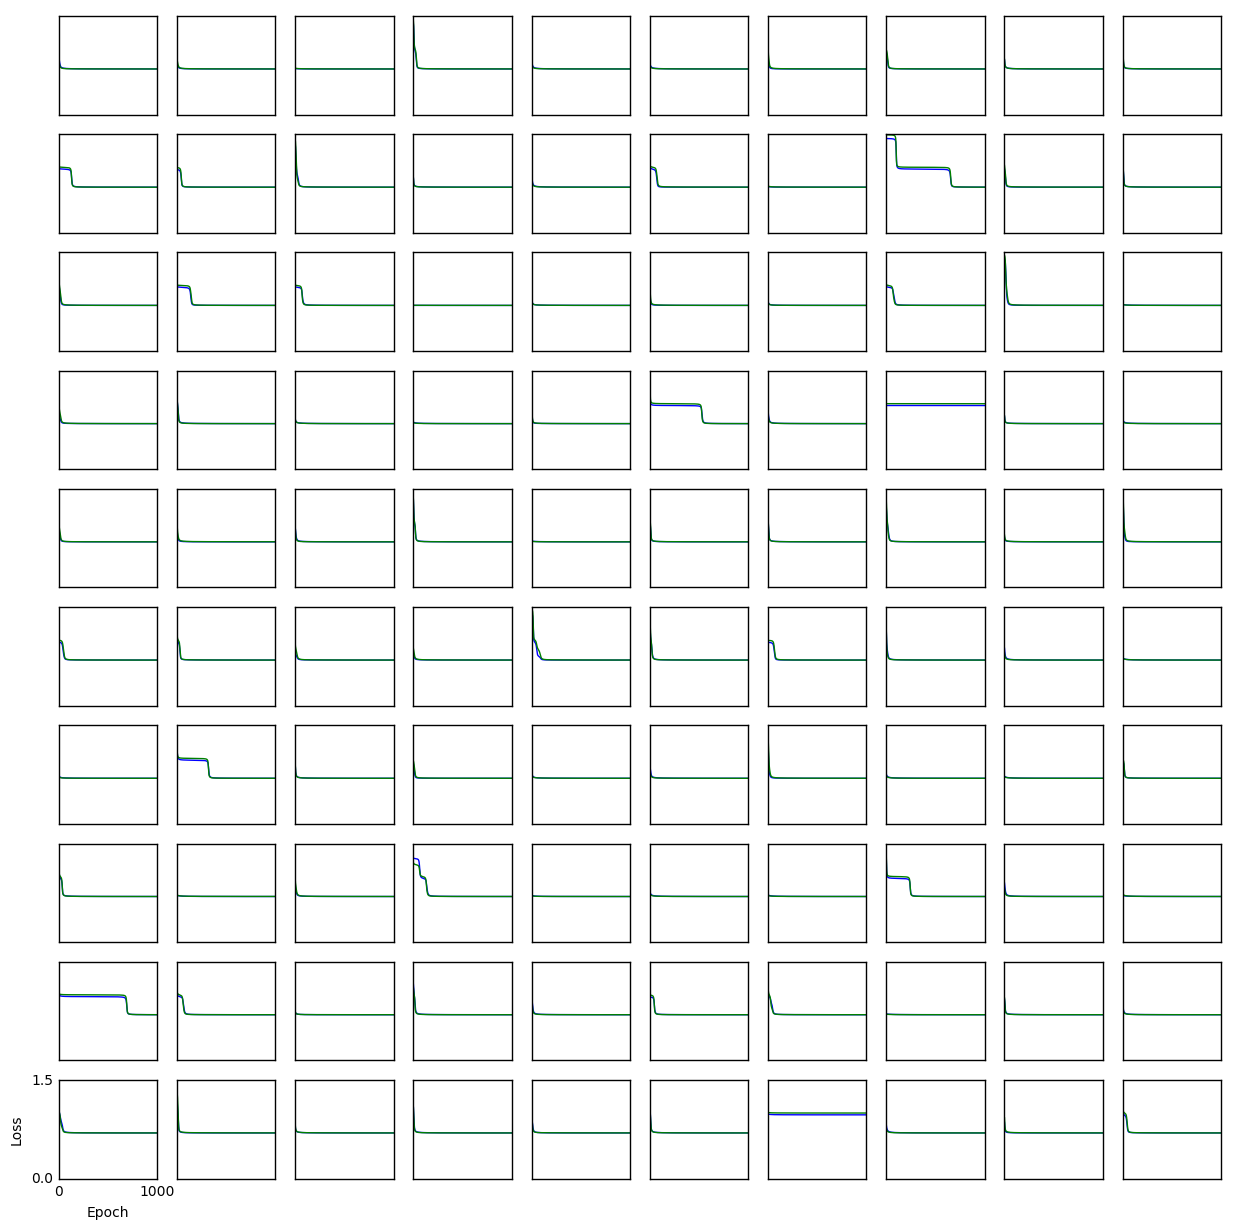

In [35]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp11/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, test_loss, color='g')
    plt.ylim(0, 1.5)
    # plt.plot(epoch, train_acc, color='r')
    # plt.plot(epoch, test_acc, color='m')
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

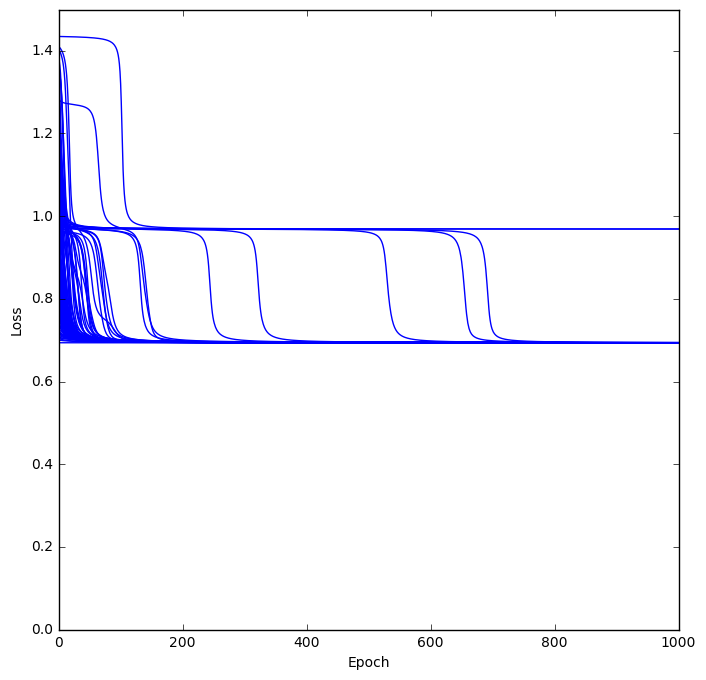

In [36]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp11/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
    # plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

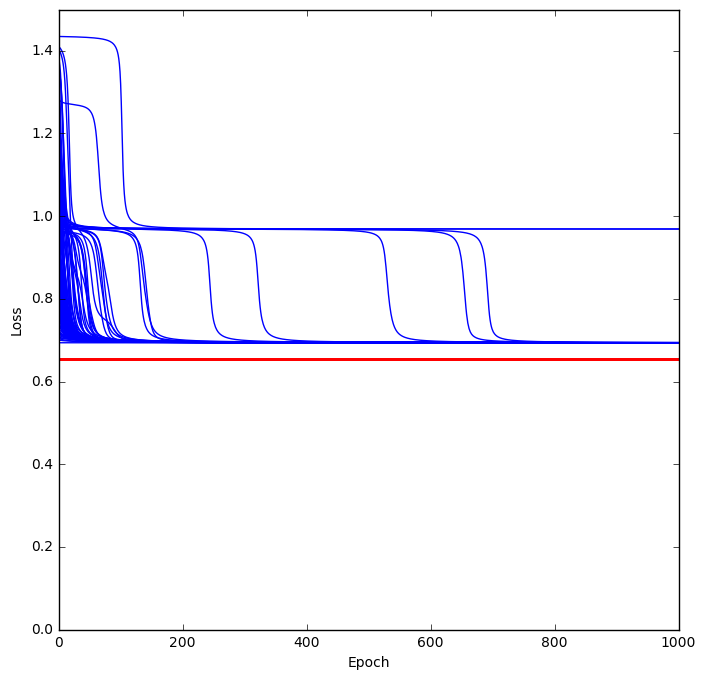

In [39]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp11/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

**All experiments have constant accuracies. Why?
=> Sigmoid activation always returns a non-negative value. With last layer of SCM (filled with 1), the final output value is also constrained to non-negative, resulting in fixed label prediction. :(**


And it seems that we have to specify accuracy_function correctly．

## With SCM. 4-2-1 (sigmoid_cross_ent {0,2} vs {1}), 2sigmoid-1, SGD, bs=10

In [57]:
%%time
for i in range(100):
    mdl = L.Classifier(SCM([4, 2, 1], act=lambda x:(F.sigmoid(x) * 2.0 - 1.0)),
                       lossfun=lambda y,t:F.sigmoid_cross_entropy(F.flatten(y), t),
                       accfun=lambda y,t:F.binary_accuracy(F.flatten(y), t))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y_02_vs_1), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y_02_vs_1), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy']))
    trn.run()

CPU times: user 1h 9min 15s, sys: 1min 37s, total: 1h 10min 53s
Wall time: 1h 14min 44s


In [58]:
os.system('mv result result_exp11')

0

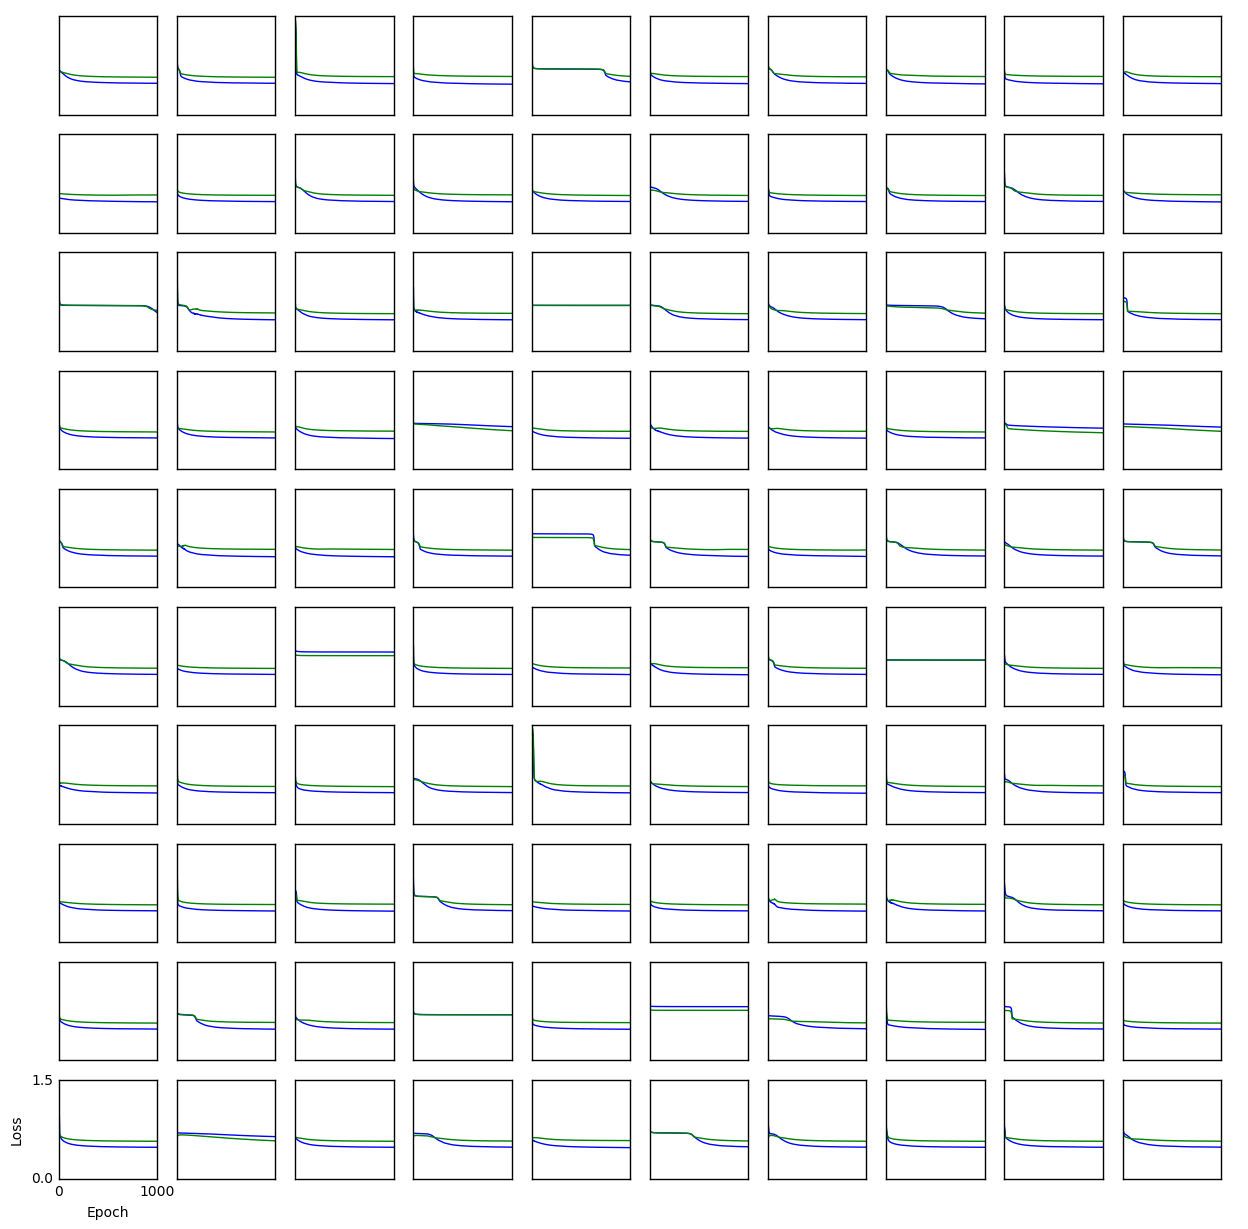

In [59]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp11/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, test_loss, color='g')
    plt.ylim(0, 1.5)
    # plt.plot(epoch, train_acc, color='r')
    # plt.plot(epoch, test_acc, color='m')
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

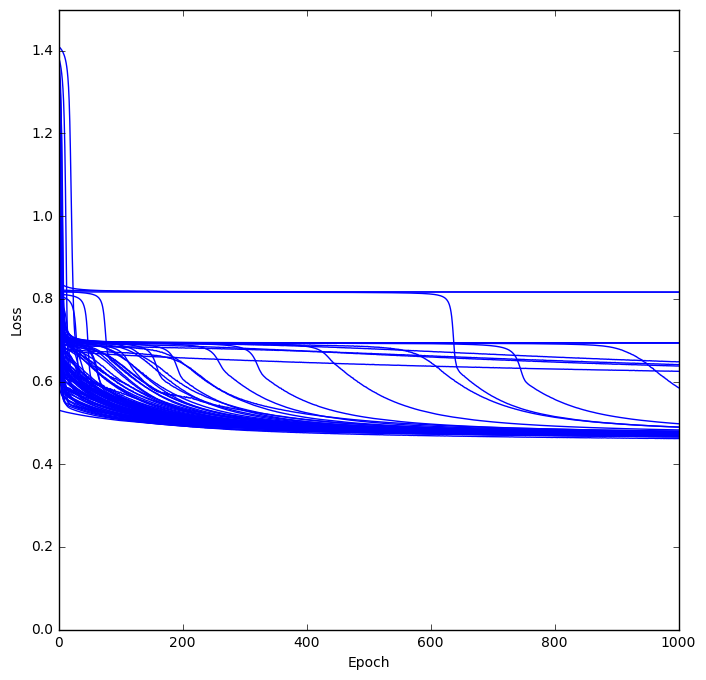

In [63]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp11/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
    # plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

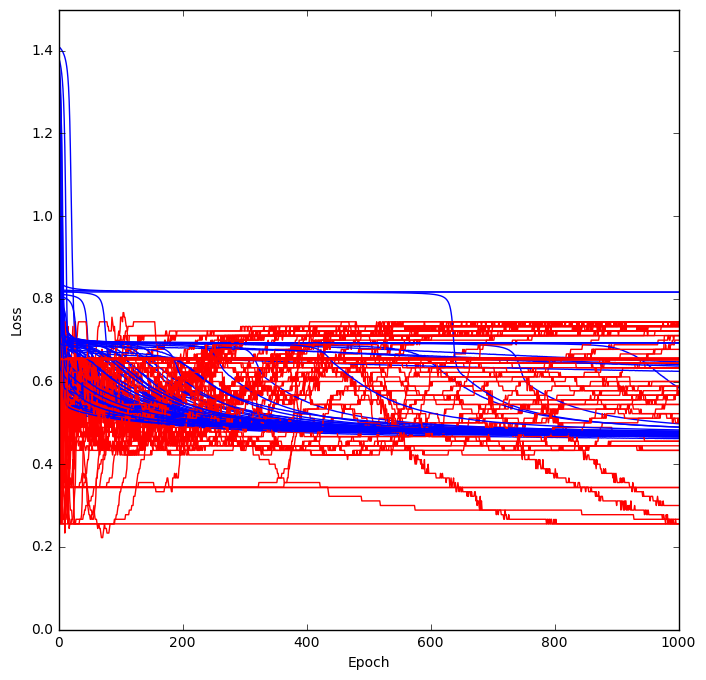

In [61]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp11/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

## 4-2-1　の MLP (not SCM) をこちらでも実験しておくか．

MLPで，　4-2-1 (sigmoid_cross_ent {0,2} vs {1}), sigmoid, SGD, bs=10

In [64]:
%%time
for i in range(100):
    mdl = L.Classifier(MLP([4, 2, 1], act=lambda x:(F.sigmoid(x) * 2.0 - 1.0)),
                       lossfun=lambda y,t:F.sigmoid_cross_entropy(F.flatten(y), t),
                       accfun=lambda y,t:F.binary_accuracy(F.flatten(y), t))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(datasets.TupleDataset(train_x, train_y_02_vs_1), 10, shuffle=True)
    test_itr = iterators.SerialIterator(datasets.TupleDataset(test_x, test_y_02_vs_1), 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    # trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy']))
    trn.run()

CPU times: user 56min 23s, sys: 1min 30s, total: 57min 54s
Wall time: 59min 2s


In [65]:
os.system('mv result result_exp11_2')

0

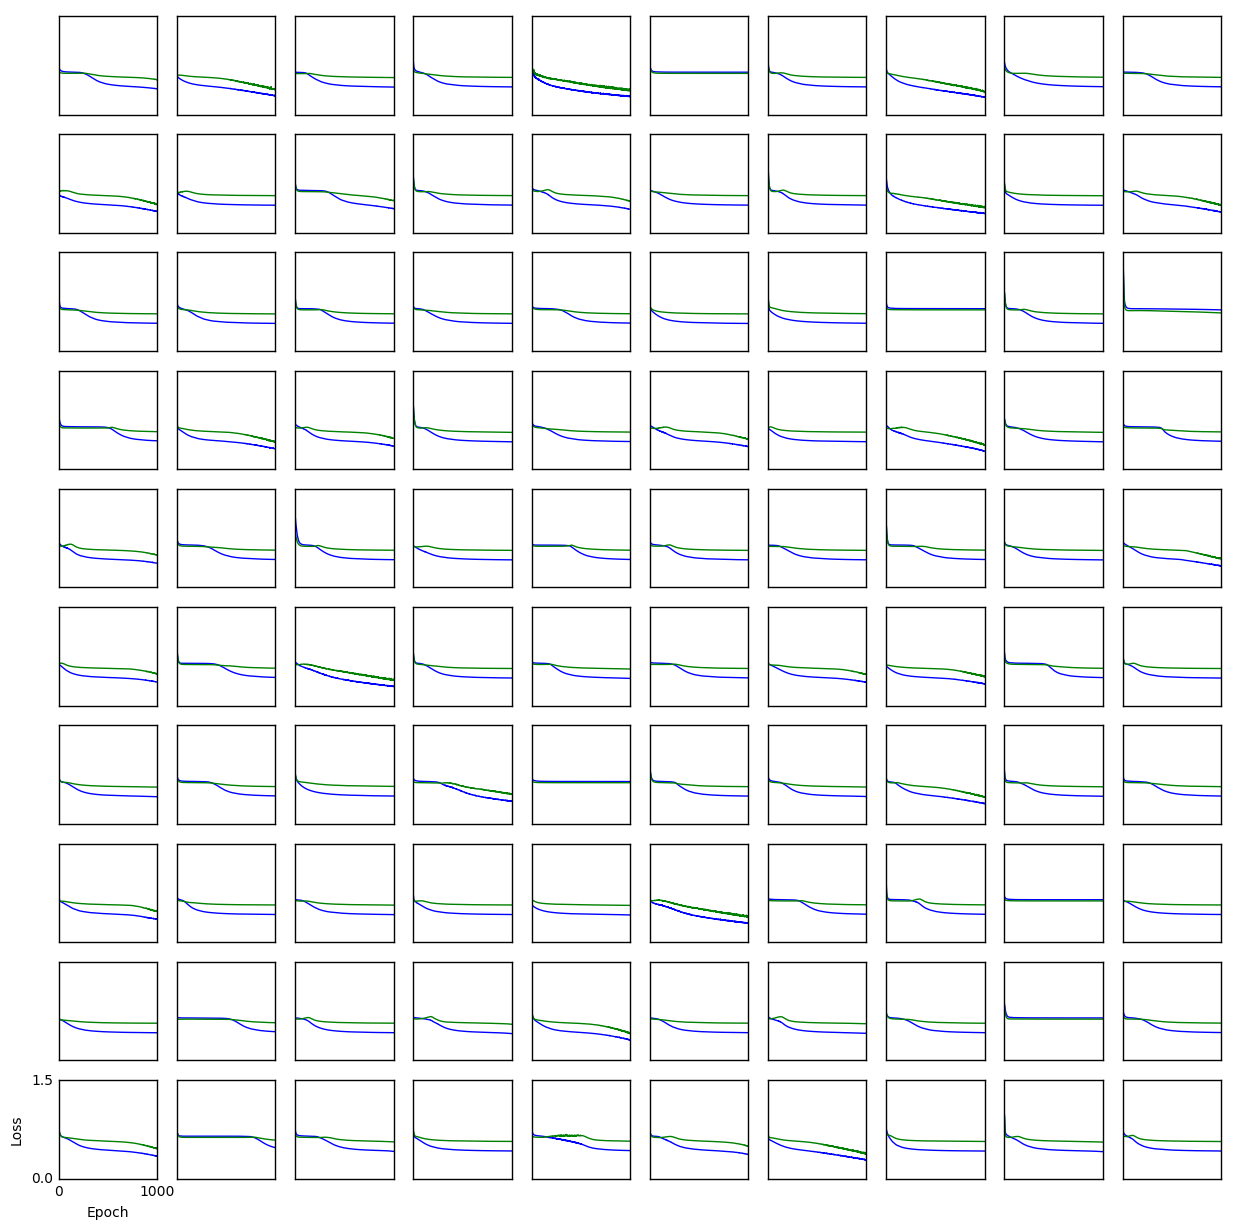

In [66]:
plt.figure(figsize=(15,15))
for i in range(100):
    with open('result_exp11_2/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.subplot(10,10,1+i)
    plt.plot(epoch, train_loss, color='b')
    plt.plot(epoch, test_loss, color='g')
    plt.ylim(0, 1.5)
    # plt.plot(epoch, train_acc, color='r')
    # plt.plot(epoch, test_acc, color='m')
    plt.yticks(plt.ylim())
    plt.xticks(plt.xlim())
    if i!=90: 
        plt.xticks(color="None")
        plt.yticks(color="None")
    else:
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
plt.show()

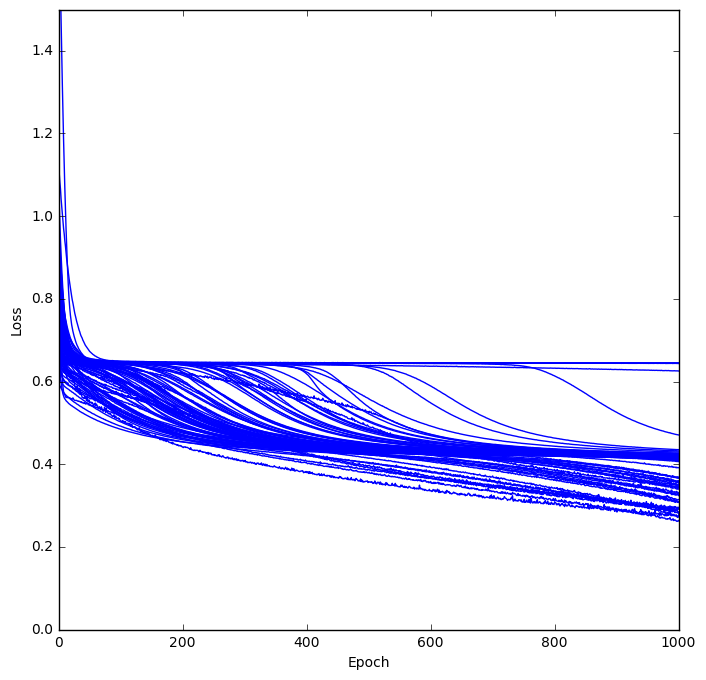

In [67]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('result_exp11_2/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    train_acc = [r['main/accuracy'] for r in rslt]
    test_acc = [r['validation/main/accuracy'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
    # plt.plot(epoch, train_acc, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.show()

# (Extra) MNIST

In [22]:
%%time
for i in range(1):
    mdl = L.Classifier(MLP([784, 20, 10], act=F.relu))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(mnist_train, 10, shuffle=True)
    test_itr = iterators.SerialIterator(mnist_test, 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (10, 'epoch'), out='result_exp6')
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
    trn.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           0.507907    0.30511               10.6624       
2           0.297003    0.265344              19.9642       
3           0.260134    0.243373              29.3324       
4           0.235491    0.226956              38.6221       
5           0.214886    0.217063              47.8634       
6           0.199024    0.201839              57.8109       
7           0.186477    0.188103              67.205        
8           0.175492    0.181083              76.4467       
9           0.167115    0.175094              85.6427       
10          0.160138    0.176451              94.8389       
CPU times: user 1min 33s, sys: 302 ms, total: 1min 34s
Wall time: 1min 34s


In [20]:
# これ全然終わらない． cpp版を使うと数倍早く終わる． mnist_cpp ディレクトリでいくつか回した跡がある・・・

In [1]:
# 結局 enatsu でパワーに任せて回した．

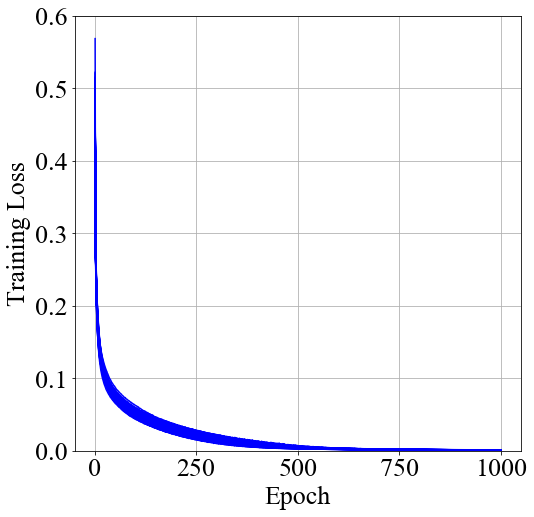

In [3]:
plt.figure(figsize=(8,8))
for i in range(100):
    with open('./iris_with_deep_learning_results/result_exp6/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid()
plt.ylim(0, 0.6)
plt.show()

In [9]:
def set_label(ax, label, loc='upper right', borderpad=-1, bbox_to_anchor=(0, 1), **kwargs):
    legend = ax.get_legend()
    if legend:
        ax.add_artist(legend)
    line, = ax.plot(np.NaN, np.NaN, color='none',label=label)
    label_legend = ax.legend(handles=[line], loc=loc, handlelength=0, handleheight=0, handletextpad=0, borderaxespad=0, borderpad=borderpad, frameon=False, bbox_to_anchor=bbox_to_anchor, **kwargs)
    label_legend.remove()
    ax.add_artist(label_legend)
    line.remove()

### IRIS と MNIST 結果を並べる．

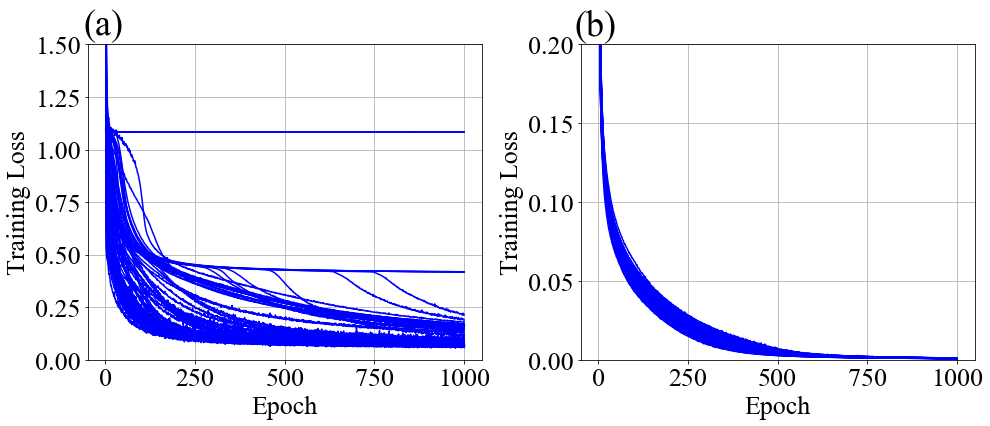

In [16]:
plt.figure(figsize=(14,6))
plt.subplots_adjust(bottom=0.15, left=0.1, right=0.98, wspace=0.25)

plt.subplot(121)
for i in range(100):
    with open('iris_with_deep_learning_results/result_exp2/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid()
set_label(plt.gca(), '(a)', fontsize=36)
plt.ylim(0, 1.5)

plt.subplot(122)
for i in range(100):
    with open('iris_with_deep_learning_results/result_exp6/log{}'.format(i), 'r') as f:
        rslt = json.load(f)
    epoch = [r['epoch'] for r in rslt]
    train_loss = [r['main/loss'] for r in rslt]
    test_loss = [r['validation/main/loss'] for r in rslt]
    plt.plot(epoch, train_loss, color='b')
    # plt.plot(epoch, test_loss, color='g')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid()
set_label(plt.gca(), '(b)', fontsize=36)
plt.ylim(0, 0.2)

plt.savefig('figures/iris_vs_mnist.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

relu activation

In [80]:
%%time
for i in range(1):
    stats_log = defaultdict(list)
    act = F.relu
    mdl = L.Classifier(MLP([784, 20, 10], act=act))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(mnist_train, 10, shuffle=True)
    test_itr = iterators.SerialIterator(mnist_test, 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))

    x_train = np.array([d[0] for d in mnist_train], dtype=np.float32)
    x_test = np.array([d[0] for d in mnist_test], dtype=np.float32)
    def compute_stats_log(trn):
        mlp = trn.updater.get_optimizer('main').target.predictor
        Q = np.dot(mlp.l0.W.data, mlp.l0.W.data.T)
        stats_log['Q'].append(Q)        
        ha_train = act(mlp.l0(x_train)).data
        haha_train = np.dot(ha_train.T, ha_train) / ha_train.shape[0]
        stats_log['haha_train'].append(haha_train)
        ha_test = act(mlp.l0(x_test)).data
        haha_test = np.dot(ha_test.T, ha_test) / ha_test.shape[0]
        stats_log['haha_test'].append(haha_test)
    trn.extend(compute_stats_log, trigger=(1, 'epoch'))
    
    trn.run()
    
    for k, v in stats_log.items():
        stats_log[k] = np.asarray(v)
    np.savez("./result/stats_log"+str(i)+".npz", **stats_log)

epoch       main/loss   validation/main/loss  elapsed_time
1           0.48919     0.296452              13.4925       
2           0.28806     0.259204              26.9142       
3           0.247439    0.232757              40.0826       
4           0.216896    0.205426              51.6264       
5           0.194559    0.193428              67.4435       
6           0.178705    0.175962              81.9151       
7           0.166555    0.1671                94.7465       
8           0.157266    0.16265               106.632       
9           0.149657    0.15347               118.329       
10          0.142996    0.150732              131.381       
11          0.137243    0.147048              144.814       
12          0.131926    0.142216              161.004       
13          0.127563    0.142525              174.078       
14          0.12355     0.141036              186.233       
15          0.119986    0.131032              202.072       
16          0.116459    0.

In [81]:
!mv ./result ./iris_with_deep_learning_results/result_exp7

In [85]:
data = np.load('./iris_with_deep_learning_results/result_exp7/stats_log0.npz')

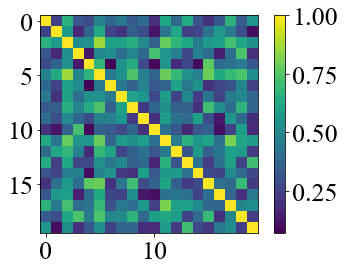

In [90]:
mat = data['haha_test'][-1]
diag = np.sqrt(np.diagonal(mat))
ovl = ((mat / diag).T / diag).T
plt.imshow(ovl); plt.colorbar(); plt.show()

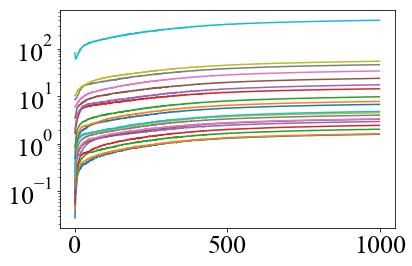

In [94]:
eigs = np.array([np.linalg.eigvalsh(_) for _ in data['haha_test']])
plt.plot(eigs); plt.yscale('log');plt.show()

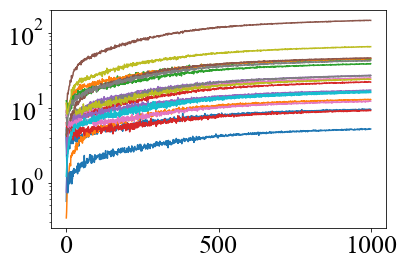

In [97]:
norms = np.array([np.diagonal(_) for _ in data['haha_test']])
plt.plot(norms); plt.yscale('log');plt.show()

sigmoid activation

In [98]:
%%time
for i in range(1):
    stats_log = defaultdict(list)
    act = F.sigmoid
    mdl = L.Classifier(MLP([784, 20, 10], act=act))
    opt = optimizers.SGD()
    opt.setup(mdl)
    train_itr = iterators.SerialIterator(mnist_train, 10, shuffle=True)
    test_itr = iterators.SerialIterator(mnist_test, 10, repeat=False)
    upd = training.StandardUpdater(train_itr, opt)
    trn = training.Trainer(upd, (1000, 'epoch'))
    trn.extend(extensions.LogReport(log_name='log'+str(i)))
    trn.extend(extensions.Evaluator(test_itr, mdl))
    trn.extend(extensions.PrintReport( ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))

    x_train = np.array([d[0] for d in mnist_train], dtype=np.float32)
    x_test = np.array([d[0] for d in mnist_test], dtype=np.float32)
    def compute_stats_log(trn):
        mlp = trn.updater.get_optimizer('main').target.predictor
        Q = np.dot(mlp.l0.W.data, mlp.l0.W.data.T)
        stats_log['Q'].append(Q)        
        ha_train = act(mlp.l0(x_train)).data
        haha_train = np.dot(ha_train.T, ha_train) / ha_train.shape[0]
        stats_log['haha_train'].append(haha_train)
        ha_test = act(mlp.l0(x_test)).data
        haha_test = np.dot(ha_test.T, ha_test) / ha_test.shape[0]
        stats_log['haha_test'].append(haha_test)
    trn.extend(compute_stats_log, trigger=(1, 'epoch'))
    
    trn.run()
    
    for k, v in stats_log.items():
        stats_log[k] = np.asarray(v)
    np.savez("./result/stats_log"+str(i)+".npz", **stats_log)

epoch       main/loss   validation/main/loss  elapsed_time
1           1.17386     0.619938              15.0151       
2           0.509189    0.413645              32.3115       
3           0.389141    0.346005              47.2109       
4           0.338892    0.310826              60.4073       
5           0.309793    0.290736              74.994        
6           0.289757    0.275402              87.8111       
7           0.274452    0.26382               104.236       
8           0.262233    0.25419               120.152       
9           0.252052    0.24511               138.306       
10          0.243006    0.239295              152.142       
11          0.235391    0.231495              164.78        
12          0.22833     0.226465              180.247       
13          0.222177    0.220138              199.922       
14          0.216423    0.216621              217.996       
15          0.211195    0.213273              230.905       
16          0.206315    0.